In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       with_info=True)

In [3]:
for data in train_ds.take(1):
    print(data)

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'SeaLake_1558.jpg'>, 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
array([[[ 53,  83, 111],
        [ 53,  83, 111],
        [ 56,  82, 115],
        ...,
        [ 54,  83, 113],
        [ 53,  84, 113],
        [ 54,  85, 114]],

       [[ 53,  83, 111],
        [ 53,  82, 112],
        [ 55,  81, 114],
        ...,
        [ 53,  84, 113],
        [ 53,  84, 113],
        [ 53,  84, 113]],

       [[ 54,  85, 114],
        [ 53,  84, 113],
        [ 54,  83, 115],
        ...,
        [ 53,  84, 112],
        [ 54,  85, 114],
        [ 53,  87, 115]],

       ...,

       [[ 55,  84, 114],
        [ 54,  85, 114],
        [ 56,  87, 116],
        ...,
        [ 52,  86, 114],
        [ 53,  84, 113],
        [ 54,  85, 114]],

       [[ 54,  85, 113],
        [ 55,  86, 114],
        [ 55,  86, 115],
        ...,
        [ 54,  85, 114],
        [ 56,  87, 116],
        [ 53,  84, 113]],

       [[ 52,  86, 113],


In [4]:
for data in valid_ds.take(1):
    print(data)

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'AnnualCrop_2634.jpg'>, 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
array([[[ 52,  92,  91],
        [ 52,  92,  91],
        [ 52,  87,  89],
        ...,
        [ 60,  94,  93],
        [ 62,  94,  93],
        [ 61,  93,  92]],

       [[ 52,  92,  91],
        [ 53,  92,  91],
        [ 52,  87,  89],
        ...,
        [ 60,  94,  93],
        [ 60,  94,  93],
        [ 60,  94,  93]],

       [[ 50,  89,  88],
        [ 51,  90,  89],
        [ 52,  87,  89],
        ...,
        [ 59,  95,  93],
        [ 60,  96,  96],
        [ 59,  95,  95]],

       ...,

       [[154, 123, 120],
        [153, 122, 119],
        [147, 116, 114],
        ...,
        [ 73,  93,  94],
        [ 70,  89,  93],
        [ 71,  90,  94]],

       [[153, 123, 121],
        [154, 124, 122],
        [154, 124, 122],
        ...,
        [ 67,  88,  91],
        [ 67,  88,  91],
        [ 67,  88,  93]],

       [[142, 112, 110

In [5]:
info

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

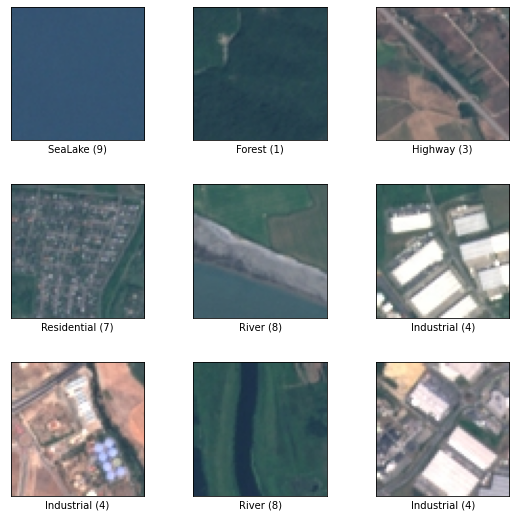

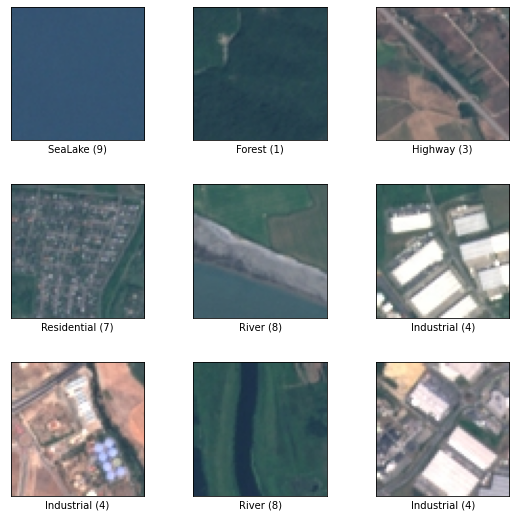

In [6]:
tfds.show_examples(train_ds, info)

,filename,image,label
0,AnnualCrop_2634.jpg,,0 (AnnualCrop)
1,Pasture_1145.jpg,,5 (Pasture)
2,HerbaceousVegetation_2725.jpg,,2 (HerbaceousVegetation)
3,HerbaceousVegetation_1985.jpg,,2 (HerbaceousVegetation)
4,Forest_748.jpg,,1 (Forest)
5,SeaLake_1551.jpg,,9 (SeaLake)
6,SeaLake_1049.jpg,,9 (SeaLake)
7,Highway_1599.jpg,,3 (Highway)
8,SeaLake_1698.jpg,,9 (SeaLake)
9,HerbaceousVegetation_7.jpg,,2 (HerbaceousVegetation)

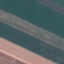
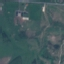
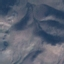
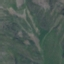
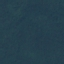
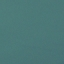
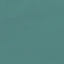
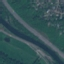
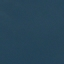
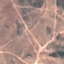

In [7]:
tfds.as_dataframe(valid_ds.take(10), info)

In [8]:
# 클래스 개수
NUM_CLASSES = info.features['label'].num_classes

In [9]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
info.features['label'].int2str(4)

'Industrial'

In [10]:
# preprocessing
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(data):
    image = tf.cast(data['image'], dtype=tf.float32)/255.0
    label = data['label']
    return image, label

train_ds = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [11]:
train_ds

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>

In [12]:
# modeling

def build_model():
    
    input_ = tf.keras.layers.Input(shape=(64, 64, 3), name='input')
    x = tf.keras.layers.BatchNormalization()(input_)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output_ = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')(x)

    model = tf.keras.models.Model(inputs=input_, outputs=output_)

    return model

model = build_model()

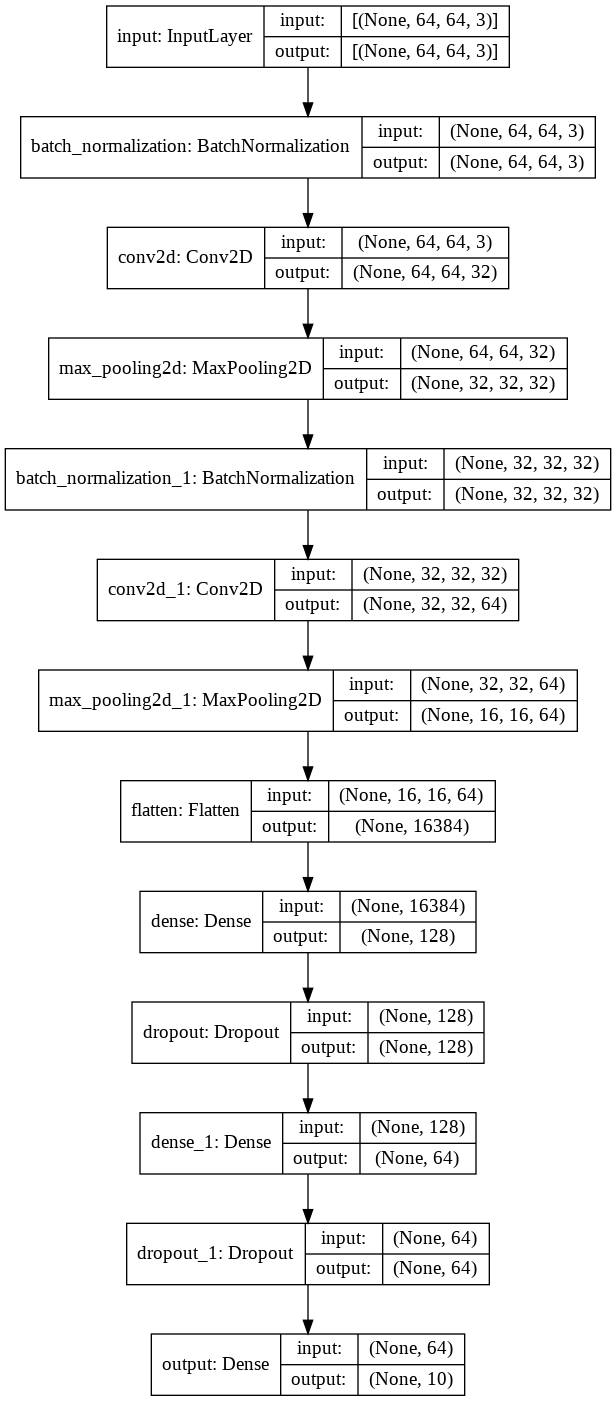

In [13]:
# 모델 구조
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
# model compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# training model
hist = model.fit(train_ds,
                 validation_data=(valid_ds),
                 epochs=20)

Epoch 1/20
338/338 [==============================] - 10s 19ms/step - loss: 1.5904 - acc: 0.4525 - val_loss: 1.8516 - val_acc: 0.3787
Epoch 2/20
338/338 [==============================] - 6s 16ms/step - loss: 1.2187 - acc: 0.5765 - val_loss: 0.9306 - val_acc: 0.6841
Epoch 3/20
338/338 [==============================] - 6s 16ms/step - loss: 1.0752 - acc: 0.6205 - val_loss: 0.8654 - val_acc: 0.7122
Epoch 4/20
338/338 [==============================] - 6s 16ms/step - loss: 0.9600 - acc: 0.6623 - val_loss: 0.8191 - val_acc: 0.7176
Epoch 5/20
338/338 [==============================] - 6s 16ms/step - loss: 0.8737 - acc: 0.6936 - val_loss: 0.8245 - val_acc: 0.7057
Epoch 6/20
338/338 [==============================] - 6s 16ms/step - loss: 0.8093 - acc: 0.7155 - val_loss: 0.6939 - val_acc: 0.7391
Epoch 7/20
338/338 [==============================] - 6s 16ms/step - loss: 0.7578 - acc: 0.7340 - val_loss: 0.6131 - val_acc: 0.7931
Epoch 8/20
338/338 [==============================] - 6s 16ms/step -

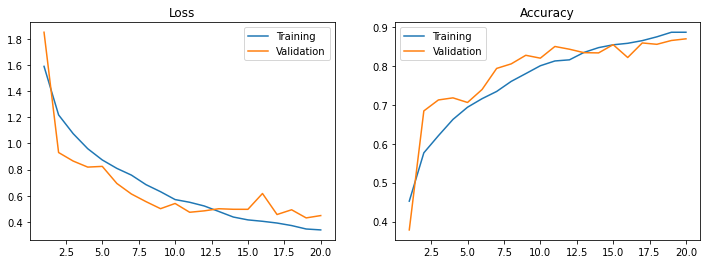

In [15]:
# training 시각화

def plot_loss_acc(history, epoch):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['acc'], history.history['val_acc']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch+1), loss, label='Training')
    axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch+1), acc, label='Training')
    axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(hist, 20)

In [16]:
# 데이터 증강(Data Augmentation)

def data_augmentation(data):
    image = data['image']
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])
    image = tf.cast(image, dtype=tf.float32)/255.0

    label = data['label']

    return image, label

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       with_info=True)

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [17]:
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# 모델 훈련
aug_hist = aug_model.fit(train_aug,
                         validation_data=(valid_aug),
                         epochs=20)

Epoch 1/20
338/338 [==============================] - 10s 26ms/step - loss: 1.9144 - acc: 0.2872 - val_loss: 1.6702 - val_acc: 0.4337
Epoch 2/20
338/338 [==============================] - 8s 22ms/step - loss: 1.6120 - acc: 0.3752 - val_loss: 1.3448 - val_acc: 0.4885
Epoch 3/20
338/338 [==============================] - 8s 23ms/step - loss: 1.4722 - acc: 0.4307 - val_loss: 1.4030 - val_acc: 0.5024
Epoch 4/20
338/338 [==============================] - 8s 22ms/step - loss: 1.3704 - acc: 0.4812 - val_loss: 1.1308 - val_acc: 0.5933
Epoch 5/20
338/338 [==============================] - 8s 22ms/step - loss: 1.3166 - acc: 0.5028 - val_loss: 1.1181 - val_acc: 0.6174
Epoch 6/20
338/338 [==============================] - 8s 22ms/step - loss: 1.2230 - acc: 0.5481 - val_loss: 0.9755 - val_acc: 0.6833
Epoch 7/20
338/338 [==============================] - 8s 22ms/step - loss: 1.1729 - acc: 0.5691 - val_loss: 0.9097 - val_acc: 0.6931
Epoch 8/20
338/338 [==============================] - 8s 22ms/step -

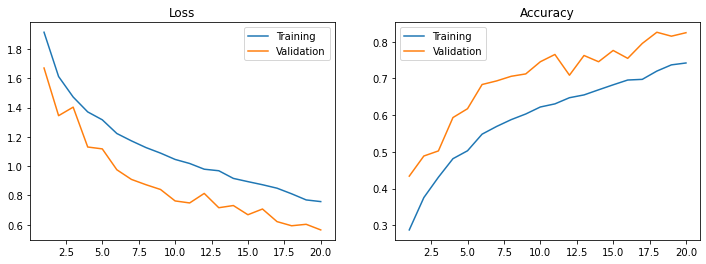

In [18]:
# training 시각화

def plot_loss_acc(history, epoch):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['acc'], history.history['val_acc']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch+1), loss, label='Training')
    axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch+1), acc, label='Training')
    axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(aug_hist, 20)